In [357]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import pandas as pd
from scipy import linalg 
import sklearn
from sklearn import *
from sklearn.impute import KNNImputer
import xgboost as xgb
from sklearn import preprocessing
from datetime import datetime
from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib.colors import LogNorm

In [356]:
def percentage_err(y_pred, dtrain):
    y_true = dtrain.get_label()
    y_min=np.minimum(np.abs(y_pred),y_true)
    err = np.median(np.abs(y_true-y_pred)/y_min)
    return 'percentage_err', err

def normalise_df(data,names=None):
    if names == None:
        names = data.columns# Create the Scaler object
    scaler = preprocessing.StandardScaler()# Fit your data on the scaler object
    scaled_data = scaler.fit_transform(data[names])
    scaled_data = pd.DataFrame(scaled_data, columns=names)
    return scaled_data

def xgb_fit(X_train,y_train,params):
    xgb_r = xgb.XGBRegressor(**params)
    xgb_r.fit(X_train,y_train,eval_metric=percentage_err)
    return xgb_r

def get_error(X_train,y_train,X_test,y_test,params):
    xgb_r=xgb_fit(X_train,y_train,params)
    y_pred = xgb_r.predict(X_test) 
    return np.abs(y_pred-y_test)/np.abs(y_test)

def try_pred(data,params,test_size):
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(data.iloc[:,data.columns != "nb_sold"], data.nb_sold,test_size = test_size) 
    xgb_r=xgb_fit(X_train,y_train,params)
    y_pred = xgb_r.predict(X_test)
    return y_test,y_pred

# Analysis

In [3]:
df=pd.read_csv('Data/Data_Scientist_-_Home_Project_-_Source_2020_12_10.csv')
df.SalesDate=pd.to_datetime(df.SalesDate) 
df.SalesDate=df.SalesDate.dt.strftime('%m-%d')

df.RankDate=pd.to_datetime(df.RankDate) 
df.sample(5)

,ProductId,DepartmentId,RankDate,Rank,SalesDate,UnitSold
26908,9645,2978,2020-11-01,21657,11-01,42
21489,53943,2978,2020-11-09,88098,11-09,2
30347,2340634,7,2020-10-27,193832,10-27,2
14000,214484,2978,2020-11-21,41538,11-21,1
15451,32606,2978,2020-11-19,51595,11-19,13


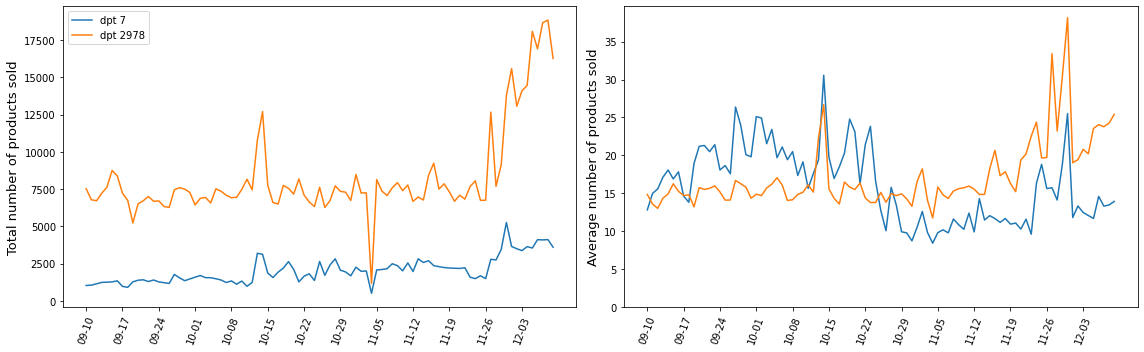

In [5]:
fig,axes=plt.subplots(1,2,figsize=(16,5))

days=list(set(df.SalesDate))
days.sort(key=lambda date: datetime.strptime(date, "%m-%d"))
nb_sold_daily_dpt7=[]
nb_sold_daily_dptnot7=[]
mean_sold_daily_dpt7=[]
mean_sold_daily_dptnot7=[]
med_sold_daily_dpt7=[]
med_sold_daily_dptnot7=[]
for d in days:
    mean_sold_daily_dpt7.append(df.loc[(df.SalesDate == d) & (df.DepartmentId==7)].UnitSold.mean())
    mean_sold_daily_dptnot7.append(df.loc[(df.SalesDate == d) & (df.DepartmentId != 7)].UnitSold.mean())
    med_sold_daily_dpt7.append(df.loc[(df.SalesDate == d) & (df.DepartmentId==7)].UnitSold.median())
    med_sold_daily_dptnot7.append(df.loc[(df.SalesDate == d) & (df.DepartmentId != 7)].UnitSold.median())
    nb_sold_daily_dpt7.append(df.loc[(df.SalesDate == d) & (df.DepartmentId==7)].UnitSold.sum())
    nb_sold_daily_dptnot7.append(df.loc[(df.SalesDate == d) & (df.DepartmentId != 7)].UnitSold.sum())

axes[0].plot(days,nb_sold_daily_dpt7,label='dpt 7')
axes[0].plot(days,nb_sold_daily_dptnot7,label='dpt 2978');
axes[0].legend();
axes[0].set_ylabel('Total number of products sold',size=13);

axes[1].plot(days,mean_sold_daily_dpt7,label='dpt 7')
axes[1].plot(days,mean_sold_daily_dptnot7,label='dpt not 7');
#axes[1].legend();
axes[1].set_ylabel('Average number of products sold',size=13);

axes[0].set_xticks(range(0,91,7))
axes[1].set_xticks(range(0,91,7))
axes[1].set_ylim(0)
for i in range(2):
    for tick in axes[i].get_xticklabels():
        tick.set_rotation(70)

fig.tight_layout();

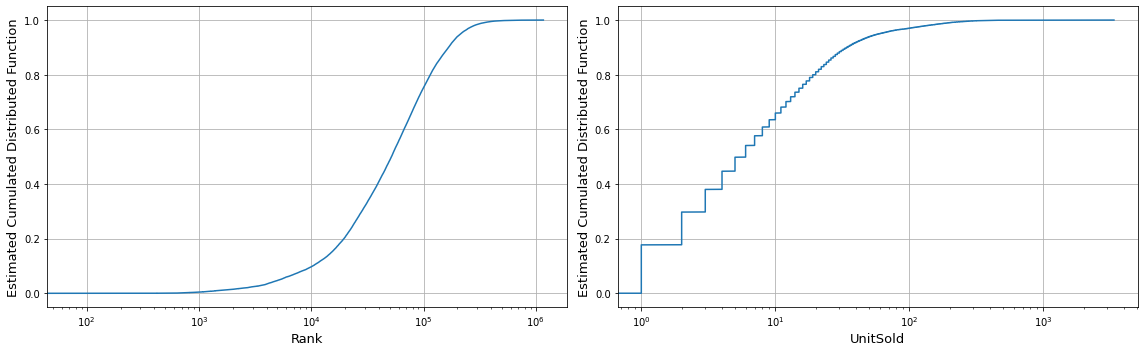

In [4]:
fig,axes=plt.subplots(1,2,figsize=(16,5))

axes[0].plot(ECDF(df.Rank).x,ECDF(df.Rank).y);
axes[0].set_xscale('log');
#axes[0].set_yscale('log');
axes[0].set_xlabel('Rank',size=13);
axes[0].set_ylabel('Estimated Cumulated Distributed Function',size=13);
axes[0].grid();

axes[1].plot(ECDF(df.UnitSold).x,ECDF(df.UnitSold).y);
axes[1].set_xscale('log');
axes[1].set_xlabel('UnitSold',size=13);
axes[1].set_ylabel('Estimated Cumulated Distributed Function',size=13);
axes[1].grid();

fig.tight_layout();

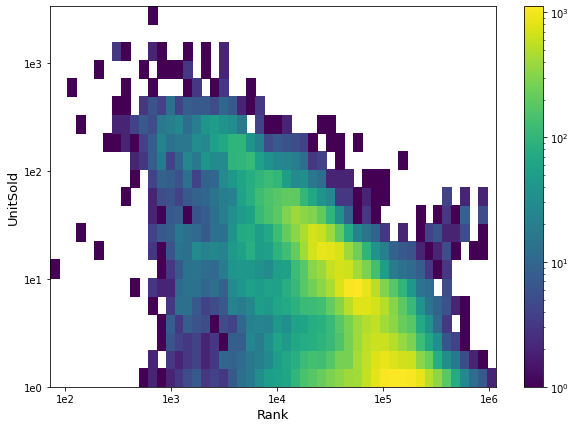

In [8]:
fig, ax = plt.subplots(figsize=(10,7))
h = ax.hist2d(np.log10(df.Rank),np.log10(df.UnitSold),bins=(50,21), norm=LogNorm())
fig.colorbar(h[3], ax=ax)
ax.set_xlabel("Rank",size=13)
ax.set_ylabel("UnitSold",size=13);
plt.xticks(range(2,7), ['1e2','1e3','1e4','1e5','1e6']);
plt.yticks(range(4), ['1e0','1e1','1e2','1e3']);

# First Model

In [194]:
med_rank1=[]
nb_sold1=[]
mean_rank1=[]

list_pid=set(df.ProductId)
df.SalesDate=df.SalesDate
for pid in list_pid:
    for m in [10,11]:
        tmp=df.loc[(df.ProductId==pid)&(df.RankDate.dt.month==m)]
        if len(tmp)>0:
            nb_sold1.append(tmp.UnitSold.sum())
            med_rank1.append(tmp.Rank.median())
            mean_rank1.append(tmp.Rank.mean())

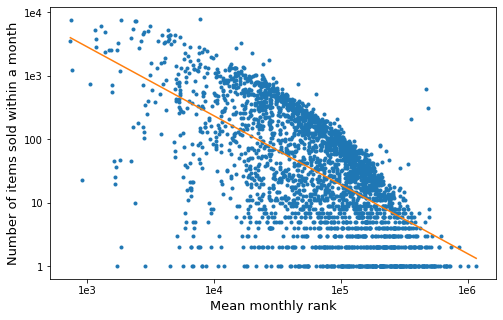

In [195]:
linreg1=st.linregress(np.log10(mean_rank1),np.log10(nb_sold1))
x=np.linspace(np.min(np.log10(mean_rank1)),np.max(np.log10(mean_rank1)),1000)
y=linreg.intercept + x*linreg.slope
plt.figure(figsize=(8,5))
plt.plot(np.log10(mean_rank1),np.log10(nb_sold1),'.');
plt.plot(x,y);
plt.xlabel('Mean monthly rank',size=13)
plt.ylabel('Number of items sold within a month',size=13);
plt.xticks([3,4,5,6],["1e3","1e4","1e5","1e6"]);
plt.yticks([0,1,2,3,4],[1,10,100,"1e3","1e4"]);

In [196]:
y_pred1=10**(linreg.intercept + np.log10(mean_rank)*linreg.slope)
y_min=np.minimum(y_pred1,nb_sold1)
error1=np.abs(y_pred1-nb_sold1)/np.abs(y_min)
print("error median = ",np.median(error1))
print("error mean = ",np.mean(error1))

error median =  2.5074007302899144
error mean =  7.455087114363206


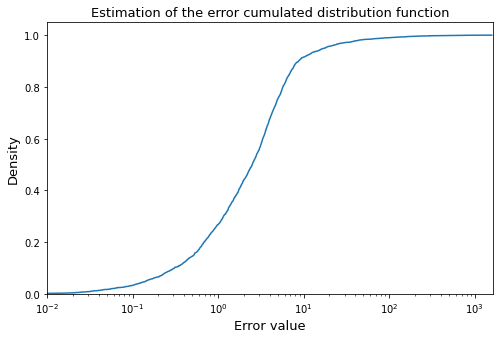

In [197]:
plt.figure(figsize=(8,5))
plt.plot(ECDF(error1).x,ECDF(error1).y);
plt.xlim(0.01)
plt.ylim(0)
plt.xlabel('Error value',size=13)
plt.ylabel('Density',size=13)
plt.title('Estimation of the error cumulated distribution function',size=13)
plt.xscale('log');

# Second Model

We first start by doing a linear regression taking independently the daily number of sales and the daily ranks. The error below is computed over those daily ranks and is not thus the one of the second model. We observe however and nevertheless that it is already much smaller than before. 

In [201]:
linreg2=st.linregress(np.log10(df.Rank),np.log10(df.UnitSold))
y_pred=10**(linreg2.intercept + np.log10(df.Rank)*linreg2.slope)
y_min=np.minimum(df.UnitSold,y_pred)
error=np.abs(y_pred-df.UnitSold)/np.abs(y_min)
print("median = ",np.median(error))
print("mean = ",np.mean(error))

median =  0.9106123424790211
mean =  1.7123125057791817


We then compute the error on the whole months of October and November

In [202]:
nb_sold2=[]
y_pred2=[]

list_pid=set(df.ProductId)
for pid in list_pid:
    for m in [10,11]:
        tmp=df.loc[(df.ProductId==pid)&(df.RankDate.dt.month==m)]
        if len(tmp)>0:
            nb_sold2.append(tmp.UnitSold.sum())
            y_pred2.append(np.sum(10**(linreg2.intercept + np.log10(tmp.Rank)*linreg2.slope)))
            

y_pred2=np.asarray(y_pred2)
y_min2=np.minimum(nb_sold2,y_pred2)
error2=np.abs(y_pred2-nb_sold2)/np.abs(y_min2)
print("median = ",np.median(error2))
print("mean = ",np.mean(error2))

median =  0.6201229339019401
mean =  1.5352851652053368


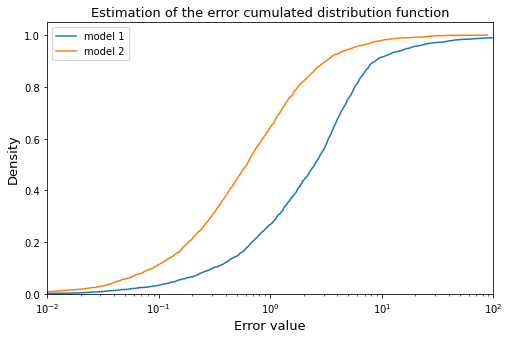

In [204]:
plt.figure(figsize=(8,5))
plt.plot(ECDF(error1).x,ECDF(error1).y,label="model 1");
plt.plot(ECDF(error2).x,ECDF(error2).y,label="model 2");
plt.xlim(0.01,100)
plt.ylim(0)
plt.legend();
plt.xlabel('Error value',size=13)
plt.ylabel('Density',size=13)
plt.title('Estimation of the error cumulated distribution function',size=13)
plt.xscale('log');

Using the departmentid does not improve a lot the prediction:

In [205]:
linreg2_dpt7=st.linregress(np.log10(df.loc[df.DepartmentId==7].Rank),np.log10(df.loc[df.DepartmentId==7].UnitSold))
nb_sold2_dpt7=[]
y_pred2_dpt7=[]

list_pid=set(df.loc[df.DepartmentId==7].ProductId)
for pid in list_pid:
    for m in [10,11]:
        tmp=df.loc[(df.ProductId==pid)&(df.RankDate.dt.month==m)]
        if len(tmp)>0:
            nb_sold2_dpt7.append(tmp.UnitSold.sum())
            y_pred2_dpt7.append(np.sum(10**(linreg2_dpt7.intercept + np.log10(tmp.Rank)*linreg2_dpt7.slope)))
            

y_pred2_dpt7=np.asarray(y_pred2_dpt7)
y_min2_dpt7=np.minimum(nb_sold2_dpt7,y_pred2_dpt7)
error2_dpt7=np.abs(y_pred2_dpt7-nb_sold2_dpt7)/np.abs(y_min2_dpt7)
print("Department 7")
print("median = ",np.median(error2_dpt7))
print("mean = ",np.mean(error2_dpt7))

linreg2_dpt2978=st.linregress(np.log10(df.loc[df.DepartmentId==2978].Rank),np.log10(df.loc[df.DepartmentId==2978].UnitSold))
nb_sold2_dpt2978=[]
y_pred2_dpt2978=[]

list_pid=set(df.loc[df.DepartmentId==2978].ProductId)
for pid in list_pid:
    for m in [10,11]:
        tmp=df.loc[(df.ProductId==pid)&(df.RankDate.dt.month==m)]
        if len(tmp)>0:
            nb_sold2_dpt2978.append(tmp.UnitSold.sum())
            y_pred2_dpt2978.append(np.sum(10**(linreg2_dpt2978.intercept + np.log10(tmp.Rank)*linreg2_dpt2978.slope)))

y_pred2_dpt2978=np.asarray(y_pred2_dpt2978)
y_min2_dpt2978=np.minimum(nb_sold2_dpt2978,y_pred2_dpt2978)
error2_dpt2978=np.abs(y_pred2_dpt2978-nb_sold2_dpt2978)/np.abs(y_min2_dpt2978)
print("Department 2978")
print("median = ",np.median(error2_dpt2978))
print("mean = ",np.mean(error2_dpt2978))

Department 7
median =  0.5744756238651779
mean =  1.4774638071218724
Department 2978
median =  0.5939185347790241
mean =  1.3205043227092328


# XGBoost 1

In [269]:
med_rank=[]
lowest_rank=[]
highest_rank=[]
dpt_id=[]
std_rank=[]
nb_update=[]
nb_sold=[]
list_pid=[]

list_pid_all=list(set(df.ProductId))
for pid in list_pid_all:
    for m in [10,11]:
        tmp=df.loc[(df.ProductId==pid)&(df.RankDate.dt.month==m)]
        if len(tmp)>0:
            nb_sold.append(tmp.UnitSold.sum())
            med_rank.append(tmp.Rank.median())
            lowest_rank.append(tmp.Rank.min())
            highest_rank.append(tmp.Rank.max())
            std_rank.append(tmp.Rank.std())
            nb_update.append(tmp.shape[0])
            list_pid.append(pid)
            dpt_id.append(df.loc[df.ProductId==pid].DepartmentId.iloc[0])

In [290]:
data=pd.DataFrame()
data["pid"]=list_pid
data["dpt_id"]=dpt_id
data["med_rank"]=med_rank
data["lowest_rank"]=lowest_rank
data["highest_rank"]=highest_rank
data["std_rank"]=std_rank
data.std_rank=data.std_rank.fillna(0)
data["nb_update"]=nb_update
data["nb_sold"]=nb_sold


scaled_data=normalise_df(data)
scaled_data['dpt_id']=data.dpt_id.replace({7:-1,2978:1})
data.head(5)

,pid,dpt_id,med_rank,lowest_rank,highest_rank,std_rank,nb_update,nb_sold
0,1005232128,7,140766.5,107301,169154,25403.685730,4,6
1,1005232128,7,138768.0,65886,234918,45258.344637,15,32
2,16385,2978,188511.0,124105,302114,55241.180996,15,19
3,16385,2978,148726.0,92808,248639,44039.441903,13,21
4,1005232134,7,105718.5,83498,239114,72387.125901,4,7


In [271]:
params={
    'n_estimators':50,
    'max_depth':10,
    'learning_rate':0.1,
}

test_size=0.1

y_pred_boost1=[]
y_test_boost1=[]
for _ in range(100):
    print(_,end="%")
    y_test,y_pred=try_pred(scaled_data,params,test_size)
    y_test=y_test*data.nb_sold.std()+data.nb_sold.mean()
    y_pred=y_pred*data.nb_sold.std()+data.nb_sold.mean()
    y_pred_boost1+=list(y_pred)
    y_test_boost1+=list(y_test)

0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%55%56%57%58%59%60%61%62%63%64%65%66%67%68%69%70%71%72%73%74%75%76%77%78%79%80%81%82%83%84%85%86%87%88%89%90%91%92%93%94%95%96%97%98%99%

median =  0.527251524617171
mean =  1.95976931347169


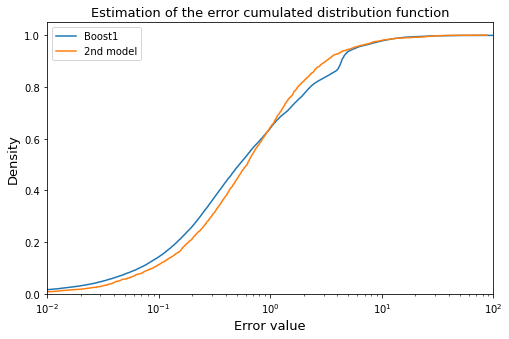

In [307]:
y_pred_boost1=np.asarray(y_pred_boost1)
y_min_boost1=np.minimum(y_test_boost1,y_pred_boost1)
error_boost1=np.abs(y_pred_boost1-y_test_boost1)/np.abs(y_min_boost1)
print("median = ",np.median(error_boost1))
print("mean = ",np.mean(error_boost1))

plt.figure(figsize=(8,5))
plt.plot(ECDF(error_boost1).x,ECDF(error_boost1).y,label="Boost1");
plt.plot(ECDF(error2).x,ECDF(error2).y,label="2nd model");
plt.legend()
plt.xlim(0.01,100)
plt.ylim(0)
plt.xlabel('Error value',size=13)
plt.ylabel('Density',size=13)
plt.title('Estimation of the error cumulated distribution function',size=13)
plt.xscale('log');

# XGBoost1 + model 2

In [308]:
reg_dpt7=np.polyfit(np.log10(df.loc[df.DepartmentId==7].Rank),np.log10(df.loc[df.DepartmentId==7].UnitSold),deg=2)
reg_dpt2978=np.polyfit(np.log10(df.loc[df.DepartmentId==2978].Rank),np.log10(df.loc[df.DepartmentId==2978].UnitSold),deg=2)

In [315]:
dpt_id=[]
std_rank=[]
nb_sold=[]
list_pid=[]
y_pred_previous=[]
med_rank=[]
lower_rank=[]
higher_rank=[]

list_pid_all=list(set(df.ProductId))
per=0
i=0
for pid in list_pid_all:
    i+=1
    if int(100*i/len(list_pid_all))>per:
        per=int(100*i/len(list_pid_all))
        print(per,end="%")
    for m in [10,11]:
        tmp=df.loc[(df.ProductId==pid)&(df.RankDate.dt.month==m)]
        if len(tmp)>0:
            nb_sold.append(tmp.UnitSold.sum())
            med_rank.append(tmp.Rank.median())
            lower_rank.append(tmp.Rank.min())
            higher_rank.append(tmp.Rank.max())
            std_rank.append(tmp.Rank.std())
            list_pid.append(pid)
            dpt_id.append(df.loc[df.ProductId==pid].DepartmentId.iloc[0])
            if tmp.DepartmentId.iloc[0] == 7:
                p=reg_dpt7
            else:
                p=reg_dpt2978
            y_pred_previous.append(np.sum(10**(p[2]+ np.log10(tmp.Rank)*p[1]+ np.log10(tmp.Rank)**2*p[0])))

1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%55%56%57%58%59%60%61%62%63%64%65%66%67%68%69%70%71%72%73%74%75%76%77%78%79%80%81%82%83%84%85%86%87%88%89%90%91%92%93%94%95%96%97%98%99%100%

In [318]:
data=pd.DataFrame()
data["dpt_id"]=dpt_id
data["med_rank"]=med_rank
data["lower_rank"]=lower_rank
data["higher_rank"]=higher_rank
data["std_rank"]=std_rank
data.std_rank=data.std_rank.fillna(0)
data["y_pred_previous"]=y_pred_previous
data["nb_sold"]=nb_sold


scaled_data=normalise_df(data)
scaled_data['dpt_id']=data.dpt_id.replace({7:-1,2978:1})
scaled_data.head(5)

,dpt_id,med_rank,lower_rank,higher_rank,std_rank,y_pred_previous,nb_sold
0,-1,0.330189,0.287843,0.232423,0.131502,-0.476201,-0.330326
1,-1,0.311952,-0.131294,0.752952,0.822720,-0.388272,-0.287138
2,1,0.765875,0.457907,1.284816,1.170261,-0.400707,-0.308732
3,1,0.402822,0.141168,0.861555,0.780285,-0.390277,-0.305410
4,-1,0.010363,0.046947,0.786164,1.767178,-0.472203,-0.328665


In [319]:
params={
    'n_estimators':300,
    'max_depth':15,
    'learning_rate':0.05,
}

test_size=0.1

y_pred_boost2=[]
y_test_boost2=[]
for _ in range(50):
    print(_,end="%")
    y_test,y_pred=try_pred(scaled_data,params,test_size)
    y_test=y_test*data.nb_sold.std()+data.nb_sold.mean()
    y_pred=y_pred*data.nb_sold.std()+data.nb_sold.mean()
    y_pred_boost2+=list(y_pred)
    y_test_boost2+=list(y_test)
print()
y_pred_boost2=np.asarray(y_pred_boost2)
y_min_boost2=np.minimum(y_test_boost2,y_pred_boost2)
error_boost2=np.abs(y_pred_boost2-y_test_boost2)/np.abs(y_min_boost2)
print("median = ",np.median(error_boost2))
print("mean = ",np.mean(error_boost2))

0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%
median =  0.389731387105266
mean =  1.5015770905984682


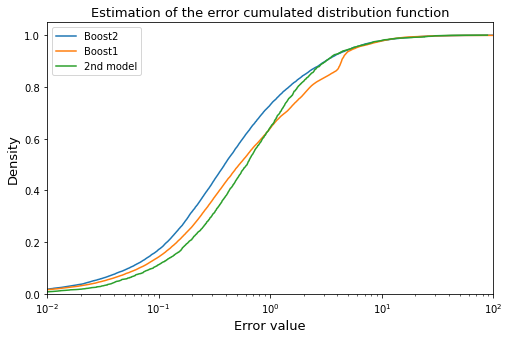

In [323]:
plt.figure(figsize=(8,5))
plt.plot(ECDF(error_boost2).x,ECDF(error_boost2).y,label="Boost2");
plt.plot(ECDF(error_boost1).x,ECDF(error_boost1).y,label="Boost1");
plt.plot(ECDF(error2).x,ECDF(error2).y,label="2nd model");
plt.legend()
plt.xlabel('Error value',size=13)
plt.ylabel('Density',size=13)
plt.title('Estimation of the error cumulated distribution function',size=13)
plt.xscale('log');
#plt.yscale('log');
plt.xlim([0.01,100]);
plt.ylim(0);

# XGBoost 1 + Model 3 + temporal data

$$ err = \frac{|US_m - \hat{US_m}|}{min(US_m, \hat{US_m})}$$

In [342]:
reg_dpt7=np.polyfit(np.log10(df.loc[df.DepartmentId==7].Rank),np.log10(df.loc[df.DepartmentId==7].UnitSold),deg=2)
reg_dpt2978=np.polyfit(np.log10(df.loc[df.DepartmentId==2978].Rank),np.log10(df.loc[df.DepartmentId==2978].UnitSold),deg=2)

dpt_id=[]
std_rank=[]
nb_sold=[]
list_pid=[]
y_pred_previous=[]
med_rank=[]
lower_rank=[]
higher_rank=[]
nb_days=[]
nb_diff_days=[]
days_density=[]

list_pid_all=list(set(df.ProductId))
per=0
i=0
for pid in list_pid_all:
    i+=1
    if int(100*i/len(list_pid_all))>per:
        per=int(100*i/len(list_pid_all))
        print(per,end="%")
    for m in [10,11]:
        tmp=df.loc[(df.ProductId==pid)&(df.RankDate.dt.month==m)]
        if len(tmp)>0:
            nb_sold.append(tmp.UnitSold.sum())
            med_rank.append(tmp.Rank.median())
            lower_rank.append(tmp.Rank.min())
            higher_rank.append(tmp.Rank.max())
            std_rank.append(tmp.Rank.std())
            list_pid.append(pid)
            dpt_id.append(df.loc[df.ProductId==pid].DepartmentId.iloc[0])
            
            days=tmp.RankDate.dt.day
            nb_days.append(max(days)-min(days))
            nb_diff_days.append(len(set(days)))
            days_density.append(nb_diff_days[-1]/(nb_days[-1]+1))
            if nb_days[-1] == 0:
                days_density[-1]=0
                
            if tmp.DepartmentId.iloc[0] == 7:
                p=reg_dpt7
            else:
                p=reg_dpt2978
            y_pred_previous.append(np.sum(10**(p[2]+ np.log10(tmp.Rank)*p[1]+ np.log10(tmp.Rank)**2*p[0])))

1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%55%56%57%58%59%60%61%62%63%64%65%66%67%68%69%70%71%72%73%74%75%76%77%78%79%80%81%82%83%84%85%86%87%88%89%90%91%92%93%94%95%96%97%98%99%100%

In [343]:
data=pd.DataFrame()
data["dpt_id"]=dpt_id
data["med_rank"]=med_rank
data["lower_rank"]=lower_rank
data["higher_rank"]=higher_rank
data["std_rank"]=std_rank
data.std_rank=data.std_rank.fillna(0)
data["nb_sold"]=nb_sold
data["y_pred_previous"]=y_pred_previous
data["nb_days"]=nb_days
data["days_density"]=days_density
#data["nb_diff_days"]=nb_diff_days

scaled_data=normalise_df(data)
scaled_data['dpt_id']=data.dpt_id.replace({7:-1,2978:1})
scaled_data.head(5)

,dpt_id,med_rank,lower_rank,higher_rank,std_rank,nb_sold,y_pred_previous,nb_days,days_density
0,-1,0.330189,0.287843,0.232423,0.131502,-0.330326,-0.476201,-1.166331,0.584593
1,-1,0.311952,-0.131294,0.752952,0.822720,-0.287138,-0.388272,0.708370,-0.092527
2,1,0.765875,0.457907,1.284816,1.170261,-0.308732,-0.400707,0.886913,-0.217611
3,1,0.402822,0.141168,0.861555,0.780285,-0.305410,-0.390277,0.083470,0.233130
4,-1,0.010363,0.046947,0.786164,1.767178,-0.328665,-0.472203,-0.095073,-1.129496


In [344]:
params={
    'n_estimators':300,
    'max_depth':15,
    'learning_rate':0.05,
}

test_size=0.1

y_pred_boost3=[]
y_test_boost3=[]
for _ in range(50):
    print(_,end="%")
    y_test,y_pred=try_pred(scaled_data,params,test_size)
    y_test=y_test*data.nb_sold.std()+data.nb_sold.mean()
    y_pred=y_pred*data.nb_sold.std()+data.nb_sold.mean()
    y_pred_boost3+=list(y_pred)
    y_test_boost3+=list(y_test)
print()
y_pred_boost3=np.asarray(y_pred_boost3)
y_min_boost3=np.minimum(y_test_boost3,y_pred_boost3)
error_boost3=np.abs(y_pred_boost3-y_test_boost3)/np.abs(y_min_boost3)
print("median = ",np.median(error_boost3))
print("mean = ",np.mean(error_boost3))

0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%
median =  0.3724140217623493
mean =  1.2911606316723372


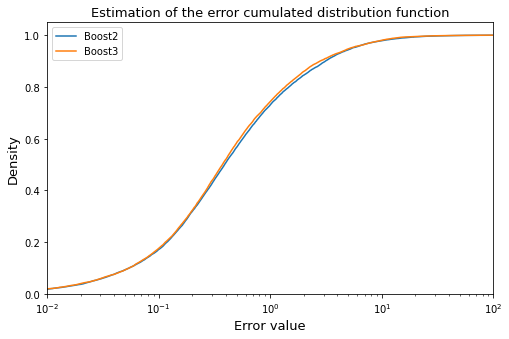

In [345]:
plt.figure(figsize=(8,5))
plt.plot(ECDF(error_boost2).x,ECDF(error_boost2).y,label="Boost2");
plt.plot(ECDF(error_boost3).x,ECDF(error_boost3).y,label="Boost3");
plt.legend()
plt.xlabel('Error value',size=13)
plt.ylabel('Density',size=13)
plt.title('Estimation of the error cumulated distribution function',size=13)
plt.xscale('log');
#plt.yscale('log');
plt.xlim([0.01,100]);
plt.ylim(0);

In [353]:
print(np.mean(error_boost3[error_boost3>np.quantile(error_boost3,0.99)]))
print(np.mean(error_boost3[error_boost3<np.quantile(error_boost3,0.99)]))

27.792646532742665
1.0225266763186747


### Analysis of the importance of each feature

In [328]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(scaled_data.iloc[:,scaled_data.columns != "nb_sold"], scaled_data.nb_sold,test_size = test_size) 
xgb_r=xgb_fit(X_train,y_train,params)

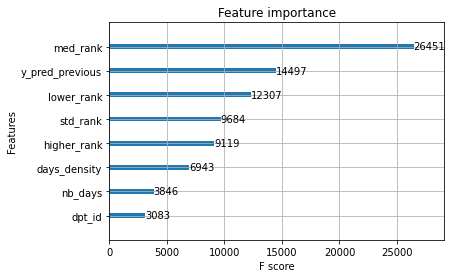

In [329]:
xgb.plot_importance(xgb_r);

### What happens to the prediction when we remove a feature?

In [186]:
nb_test=50
list_cols=['dpt_id', 'med_rank', 'lower_rank', 'higher_rank', 'std_rank','y_pred3',
           'nb_days', 'nb_diff_days', 'days_density']
error_boost_cols=[]
for forbid_col in list_cols:
    print(forbid_col,end=' - ')
    scaled_data2=scaled_data.iloc[:,scaled_data.columns != forbid_col]
    error_boost=[]
    for _ in range(nb_test):
        y_test,y_pred=try_pred(scaled_data2,params,test_size)
        y_test=y_test*data.nb_sold.std()+data.nb_sold.mean()
        y_pred=y_pred*data.nb_sold.std()+data.nb_sold.mean()
        y_pred=np.asarray(y_pred)
        y_min=np.minimum(y_test,y_pred)
        error_boost+=list(np.abs(y_pred-y_test)/np.abs(y_min))
    error_boost_cols.append(np.asarray(error_boost))
error_boost_cols=np.asarray(error_boost_cols)

dpt_id - med_rank - lower_rank - higher_rank - std_rank - y_pred3 - nb_days - nb_diff_days - days_density - 

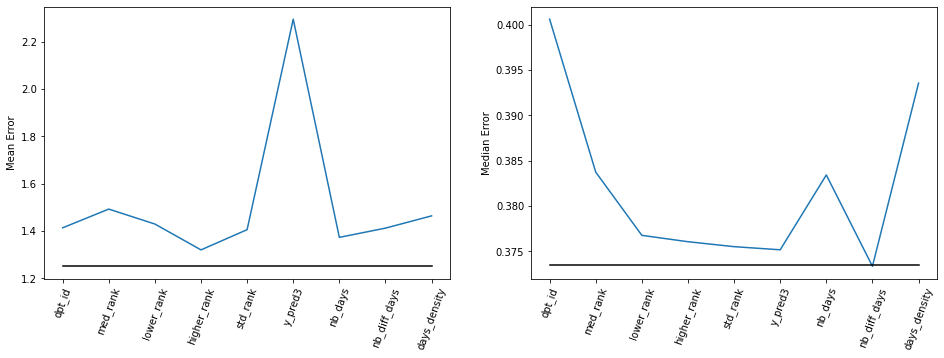

In [187]:
fig,axes=plt.subplots(1,2,figsize=(16,5))
axes[0].plot(list_cols,np.mean(error_boost_cols,1))
axes[0].plot(list_cols,np.mean(error_boost2)*np.ones(len(list_cols)),'k')
axes[0].set_ylabel("Mean Error")

axes[1].plot(list_cols,np.median(error_boost_cols,1))
axes[1].plot(list_cols,np.median(error_boost2)*np.ones(len(list_cols)),'k')
axes[1].set_ylabel("Median Error")

for i in range(2):
    for tick in axes[i].get_xticklabels():
        tick.set_rotation(70)

The mean error and the median error increase, hence each feature is important!